In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn import datasets
from sklearn import linear_model
from sklearn.svm import l1_min_c
#from sklearn.linear_model import LinearRegression

import h2o4gpu

## Linear Regression

In [2]:
# y = ax + b

X = np.array([1,2,3,4,5,6,7,8,9,10])
X = X.astype(float)

y = 2*X + 10

X = X[:, np.newaxis]
X = np.hstack([X, np.ones((X.shape[0],1), dtype=X.dtype)])

lm = h2o4gpu.LinearRegression()
lm.fit(X, y)

print('Linear Regression')
print('Predicted:', lm.predict(np.array([[15.0, 1.0], [16.0, 1.0]])))
print('Coefficients:', lm.X)

# sklearn
X = np.array([1,2,3,4,5,6,7,8,9,10])
X = X[:, np.newaxis]
# Values to predict
X_test = np.array([15, 16])
X_test = X_test[:, np.newaxis]

sk_lm = linear_model.LinearRegression()
sk_lm.fit(X, np.transpose(y))

print('------------')
print('scikit-learn')
print('Predicted:', sk_lm.predict(X_test))
print('Coefficients:', sk_lm.coef_)

Linear Regression
Predicted: [[ 39.93816196  41.93188356]]
Coefficients: [[  1.9937216   10.03233797]]
------------
scikit-learn
Predicted: [ 40.  42.]
Coefficients: [ 2.]


## Logistic Regression

In [57]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

dfX = pd.DataFrame(X)
dfy = pd.DataFrame(y)

dfy.loc[:,0].value_counts()

2    50
1    50
0    50
Name: 0, dtype: int64

In [58]:
# making it a binary problem
X = X[y != 2]
y = y[y != 2]

# subtracting the mean
X -= np.mean(X, 0)

In [59]:
X_test = X[np.r_[40:50,90:100]]
y_test = y[np.r_[40:50,90:100]]
X = X[np.r_[:40,50:90]]
y = y[np.r_[:40,50:90]]

In [60]:
cs = l1_min_c(X, y, loss='log') * np.logspace(0, 3)

In [61]:
cs

array([  0.01751313,   0.02016454,   0.02321736,   0.02673236,
         0.03077952,   0.0354394 ,   0.04080476,   0.04698241,
         0.05409533,   0.06228512,   0.0717148 ,   0.08257209,
         0.09507313,   0.10946676,   0.12603952,   0.14512133,
         0.16709203,   0.19238899,   0.2215158 ,   0.25505227,
         0.29366601,   0.3381257 ,   0.38931637,   0.44825708,
         0.51612114,   0.5942595 ,   0.68422766,   0.78781658,
         0.90708839,   1.04441739,   1.20253738,   1.38459601,
         1.59421747,   1.83557467,   2.11347223,   2.4334422 ,
         2.80185415,   3.22604198,   3.71444989,   4.27680052,
         4.92428844,   5.66980305,   6.52818515,   7.51652235,
         8.65448925,   9.96473911,  11.47335476,  13.21036789,
        15.21035681,  17.51313485])

In [62]:
start = time.time()
clf = linear_model.LogisticRegression(C = 1.0, penalty = 'l1'
                         #, tol=1e-6
                        )
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print(time.time() - start)

0.05437636375427246


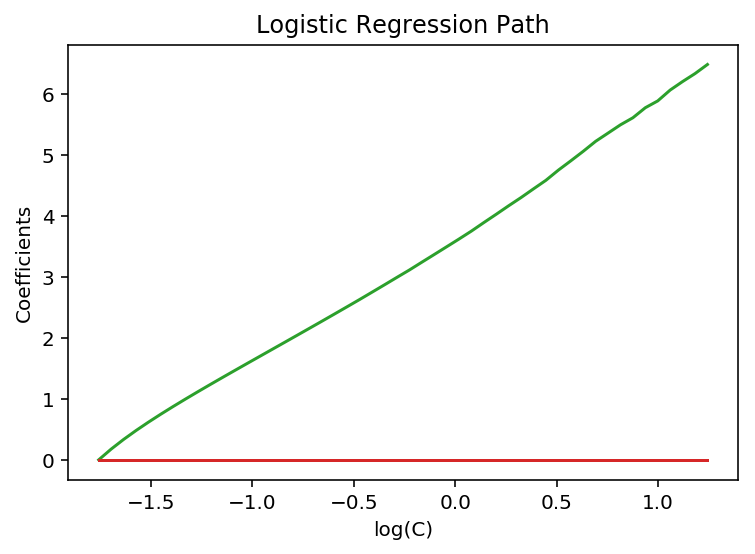

(50, 4)


array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.1755772 ,  0.        ],
       [ 0.        ,  0.        ,  0.33361698,  0.        ],
       [ 0.        ,  0.        ,  0.47966205,  0.        ],
       [ 0.        ,  0.        ,  0.61713406,  0.        ],
       [ 0.        ,  0.        ,  0.74834557,  0.        ],
       [ 0.        ,  0.        ,  0.87489153,  0.        ],
       [ 0.        ,  0.        ,  0.99789961,  0.        ],
       [ 0.        ,  0.        ,  1.11840165,  0.        ],
       [ 0.        ,  0.        ,  1.23686494,  0.        ],
       [ 0.        ,  0.        ,  1.35387686,  0.        ],
       [ 0.        ,  0.        ,  1.46985041,  0.        ],
       [ 0.        ,  0.        ,  1.58511496,  0.        ],
       [ 0.        ,  0.        ,  1.69991747,  0.        ],
       [ 0.        ,  0.        ,  1.81472145,  0.        ],
       [ 0.        ,  0.        ,  1.92948963,  0.        ],
       [ 0.        ,  0.

In [63]:
coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()
print(coefs_.shape)
coefs_

In [64]:
classification = True
lambda_min_ratio = 1e-9 
n_folds = 5
n_lambdas = 20
n_alphas = 3
give_full_path = 0
n_gpus = 1
verbose = 0
family = "logistic" if classification else "elasticnet"

In [66]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [75]:
logreg = h2o4gpu.LogisticRegression(alpha_max = 1.0
                                    , alpha_min = 1.0
                                   )

In [76]:
start = time.time()
model = logreg.fit(X, y)
print(time.time() - start)
model

0.9776768684387207


In [77]:
y_pred_h2o = model.predict(X_test)
y_pred_h2o
model.

array([[ 0.5163793 ,  0.5907447 ,  0.58417682,  0.55988864,  0.50492926,
         0.54436646,  0.47789073,  0.55462687,  0.45261082,  0.49840083,
         0.53462668,  0.47810279,  0.50125192,  0.59493801,  0.54116415,
         0.50917303,  0.52633727,  0.45435158,  0.602883  ,  0.52891951]])

In [69]:
print("Xvsalpha")
print(logreg.x_vs_alphapure)
print(model.x_vs_alphapure)

print("np.shape(Xvsalpha)")
print(np.shape(logreg.x_vs_alphapure))
print(np.shape(model.x_vs_alphapure))

error_train = logreg.error_vs_alpha
if classification:
    print("logloss_train")
else:
    print("rmse_train")
print(error_train)

error_train = model.error_vs_alpha
if classification:
    print("logloss_train")
else:
    print("rmse_train")
print(error_train)

print("Best lambdas")
lambdas = logreg.lambdas_best
print(lambdas)
print(model.lambdas_best)

print("Best alphas")
alphas = logreg.alphas_best
print(alphas)
print(model.alphas_best)

print("Best tols")
tols = logreg.tols_best
print(tols)
print(model.tols_best)

Xvsalpha
[[-0.5599661  -0.01793422 -0.08567183  0.66957007]]
[[-0.5599661  -0.01793422 -0.08567183  0.66957007]]
np.shape(Xvsalpha)
(1, 4)
(1, 4)
logloss_train
[[ 0.68617965 -1.         -1.        ]]
logloss_train
[[ 0.68617965 -1.         -1.        ]]
Best lambdas
[[  1.48219694e-323]]
[[  1.48219694e-323]]
Best alphas
[[ 1.]]
[[ 1.]]
Best tols
[[ 0.01]]
[[ 0.01]]


In [70]:
logreg.x_vs_alphapure

array([[-0.5599661 , -0.01793422, -0.08567183,  0.66957007]])

In [71]:
model.X_full

AttributeError: 'LogisticRegression' object has no attribute 'x_vs_alpha_lambdapure'

In [19]:
model.X_best

array([[  4.63047361e-14,  -2.22300390e-14,  -6.35172960e-15,
         -3.97275784e-14]])

In [20]:
logreg = h2o4gpu.LogisticRegression(alpha_max = 1.0, 
                                    alpha_min = 1.0,
                                    give_full_path = 1,
                                    n_lambdas = 50,
                                    glm_stop_early = False
                                   )
start = time.time()
logreg.fit(X, y)
print(time.time() - start)
logreg.lambdas_full

130.17379236221313


array([[[  3.55727265e-322]],

       [[  2.56914136e-322]],

       [[  1.82804289e-322]],

       [[  1.33397724e-322]],

       [[  9.38724727e-323]],

       [[  6.91691904e-323]],

       [[  4.94065646e-323]],

       [[  3.45845952e-323]],

       [[  2.47032823e-323]],

       [[  1.97626258e-323]],

       [[  1.48219694e-323]],

       [[  9.88131292e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [

In [21]:
logreg.X_full[49]

array([[  5.15642012e-14,  -2.50380863e-14,  -5.06618698e-15,
         -4.68184728e-14]])